# response tmax bound

This notebook shows how to bound the maximum duration of your response function. For now this is only implemented for the Gamma response function in combination with the LmfitSolver.

As an example the data is used from the basic model notebook.

In [ ]:
import pandas as pd

import pastas as ps

ps.show_versions()

Pastas version: 1.11.0.dev0
Python version: 3.12.10
NumPy version: 2.2.6
Pandas version: 2.3.1
SciPy version: 1.16.1
Matplotlib version: 3.10.5
Numba version: 0.61.2


### 1. Importing time series data
See the [basic model notebook](basic_model.ipynb) for more information.

In [2]:
# Import groundwater time seriesm and squeeze to Series object
gwdata = pd.read_csv(
    "data/head_nb1.csv", parse_dates=["date"], index_col="date"
).squeeze()

# Import observed precipitation series
precip = pd.read_csv(
    "data/rain_nb1.csv", parse_dates=["date"], index_col="date"
).squeeze()

# Import observed evaporation series
evap = pd.read_csv(
    "data/evap_nb1.csv", parse_dates=["date"], index_col="date"
).squeeze()

# Calculate the recharge to the groundwater
recharge = (precip - evap).dropna()
recharge.name = "recharge"  # set name if pandas series

### 2. Create the time series model
First we create a timeseries model without a bound for the maximum duration of the response. 

In [3]:
# Create a model object by passing it the observed series
ml = ps.Model(gwdata, name="GWL")

# Add the recharge data as explanatory variable
sm = ps.StressModel(recharge, ps.Gamma(), name="recharge", settings="evap")
ml.add_stressmodel(sm)

ml.solve(report=False)
print(
    f"the tmax of the recharge response is {ml.get_response_tmax('recharge'):.0f} days"
)

the tmax of the recharge response is 784 days


### 3. Model with response tmax bound
Now we create a timeseries model with a maximum bound for the response.

In [4]:
# Create a model object by passing it the observed series
ml2 = ps.Model(gwdata, name="500d")

# Add the recharge data as explanatory variable
sm2 = ps.StressModel(
    recharge, ps.rfunc.Gamma_tmaxbound(500), name="recharge", settings="evap"
)
ml2.add_stressmodel(sm2)

ml2.solve(solver=ps.solver.LmfitSolve())
ml2.get_response_tmax("recharge")

Fit report 500d                   Fit Statistics
nfev    64                     EVP         89.71
nobs    644                    R2           0.90
noise   False                  RMSE         0.14
tmin    1985-11-14 00:00:00    AICc     -2544.23
tmax    2015-06-28 00:00:00    BIC      -2526.42
freq    D                      Obj         12.24
warmup  3650 days 00:00:00     ___              
solver  LmfitSolve             Interp.        No

Parameters (4 optimized)
                  optimal     initial   vary
recharge_A     522.207011  215.674528   True
recharge_n       1.555224    1.000000   True
recharge_tmax  500.000000   69.077553   True
recharge_a      60.536122   10.000000  False
constant_d      27.656983   27.900078   True

Warnings! (1)
Parameter 'recharge_tmax' on upper bound: 5.00e+02


np.float64(499.9999999808999)

In [5]:
# Create a model object by passing it the observed series
ml3 = ps.Model(gwdata, name="200d")

# Add the recharge data as explanatory variable
sm3 = ps.StressModel(
    recharge, ps.rfunc.Gamma_tmaxbound(200), name="recharge", settings="evap"
)
ml3.add_stressmodel(sm3)

ml3.solve(solver=ps.solver.LmfitSolve())
ml3.get_response_tmax("recharge")

Fit report 200d                   Fit Statistics
nfev    211                    EVP         74.06
nobs    644                    R2           0.74
noise   False                  RMSE         0.22
tmin    1985-11-14 00:00:00    AICc     -1948.48
tmax    2015-06-28 00:00:00    BIC      -1930.67
freq    D                      Obj         30.86
warmup  3650 days 00:00:00     ___              
solver  LmfitSolve             Interp.        No

Parameters (4 optimized)
                  optimal     initial   vary
recharge_A     312.036113  215.674528   True
recharge_n       5.445975    1.000000   True
recharge_tmax  200.000000   69.077553   True
recharge_a      12.868106   10.000000  False
constant_d      27.754273   27.900078   True

Warnings! (1)
Parameter 'recharge_tmax' on upper bound: 2.00e+02


np.float64(199.99999999962355)

### 4. Compare models

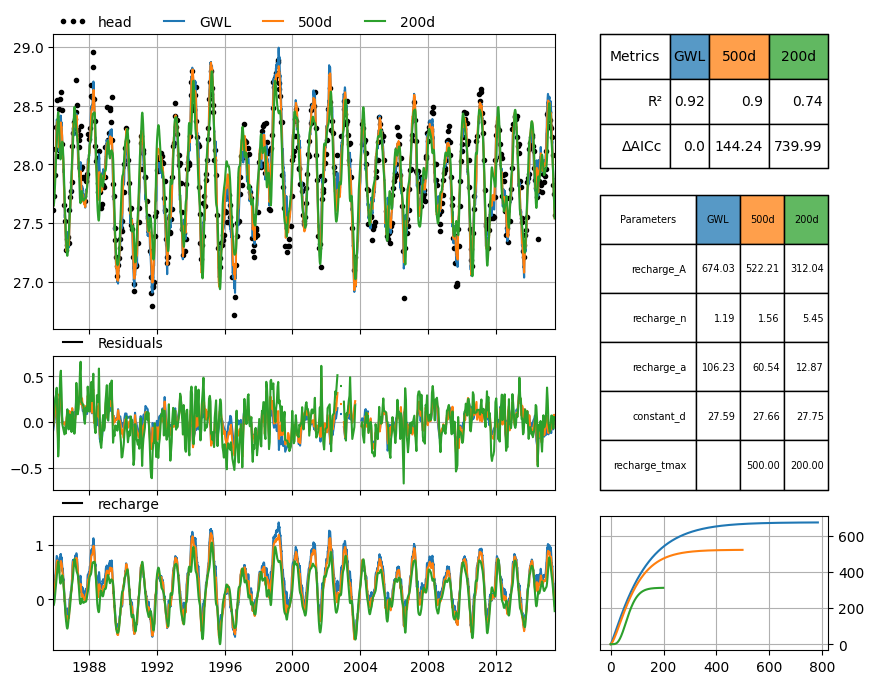

In [6]:
mc = ps.CompareModels(models=[ml, ml2, ml3])
mc.plot()

### 5. Another model

Fit report B09B0533_1_00           Fit Statistics
nfev    12                     EVP          75.31
nobs    2980                   R2            0.75
noise   True                   RMSE          0.14
tmin    2016-02-05 15:00:00    AICc     -16326.44
tmax    2024-11-29 13:00:00    BIC      -16290.47
freq    D                      Obj           6.20
warmup  3650 days 00:00:00     ___               
solver  LeastSquares           Interp.        Yes

Parameters (6 optimized)
                 optimal       initial  vary
recharge_A      0.801136      0.450825  True
recharge_n      0.550593      0.414585  True
recharge_a   9999.999989  10000.000000  True
recharge_f     -1.023945     -0.837449  True
constant_d     -1.492330     -1.515057  True
noise_alpha    10.198011      1.000000  True

Warnings! (3)
Parameter 'recharge_a' on upper bound: 1.00e+04
Response tmax for 'recharge' > than calibration period.
Response tmax for 'recharge' > than warmup period.

the tmax of the recharge response is 5

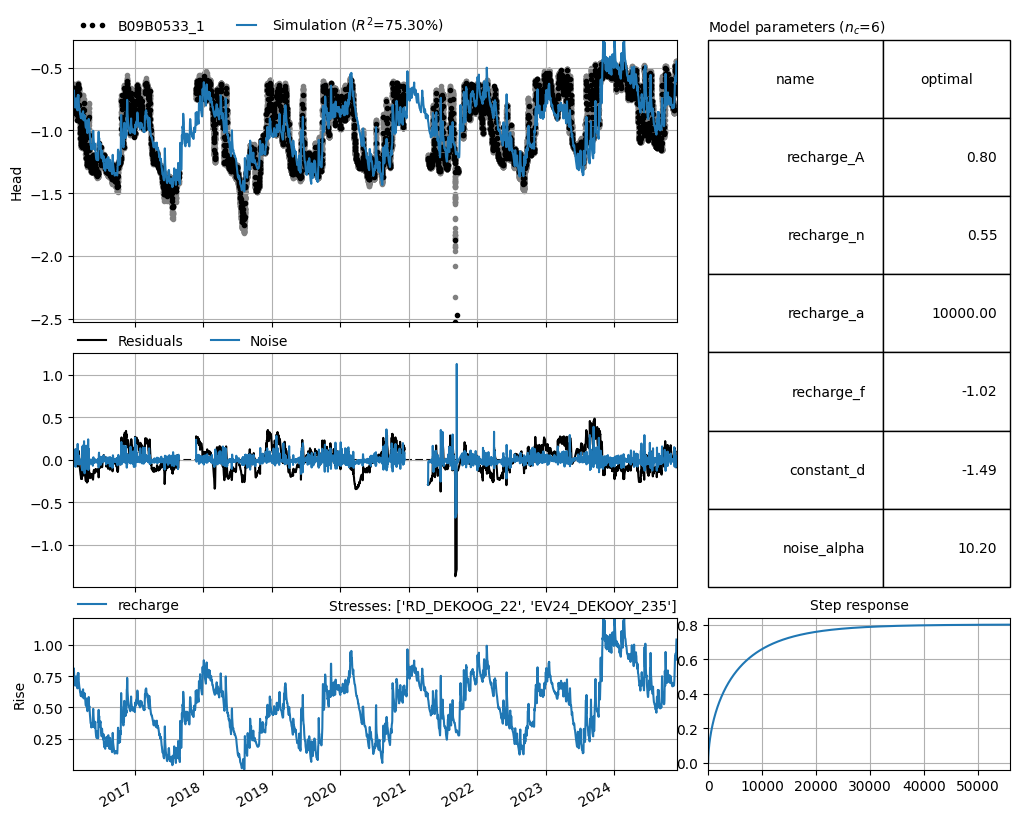

In [ ]:
# consider this model with a response function with a high response tmax
ml = ps.io.load("data/B09B0533_1_00.pas")
# ml.del_noisemodel()
ml.solve()
ml.plots.results()
print(
    f"\nthe tmax of the recharge response is {ml.get_response_tmax('recharge'):.0f} days"
)

In [8]:
# create copy with tmax bound
ml2 = ml.copy(name="1000D")
sm = ml2.stressmodels["recharge"]
sm2 = ps.RechargeModel(
    prec=sm.stress[0].series_original,
    evap=sm.stress[1].series_original,
    rfunc=ps.rfunc.Gamma_tmaxbound(1000),
)
ml2.del_stressmodel("recharge")
ml2.add_stressmodel(sm2)
# ml2.solve()
ml2.solve(solver=ps.LmfitSolve())

print(
    f"\nthe tmax of the recharge response is {ml2.get_response_tmax('recharge'):.0f} days"
)

Fit report 1000D                   Fit Statistics
nfev    95                     EVP          76.10
nobs    2980                   R2            0.76
noise   True                   RMSE          0.14
tmin    2016-02-05 15:00:00    AICc     -16347.38
tmax    2024-11-29 13:00:00    BIC      -16311.41
freq    D                      Obj          12.30
warmup  3650 days 00:00:00     ___               
solver  LmfitSolve             Interp.        Yes

Parameters (6 optimized)
                  optimal    initial   vary
recharge_A       0.079700   0.124175   True
recharge_n       0.652099   1.000000   True
recharge_tmax  407.985492  69.077553   True
recharge_a      68.957956  10.000000  False
recharge_f      -0.910283  -1.000000   True
constant_d      -1.098211  -1.515057   True
noise_alpha      9.845629   1.000000   True

the tmax of the recharge response is 408 days


Fit report B09B0533_1_02           Fit Statistics
nfev    27                     EVP          80.21
nobs    2980                   R2            0.80
noise   True                   RMSE          0.13
tmin    2016-02-05 15:00:00    AICc     -16374.17
tmax    2024-11-29 13:00:00    BIC      -16326.23
freq    D                      Obj           6.09
warmup  3650 days 00:00:00     ___               
solver  LeastSquares           Interp.        Yes

Parameters (8 optimized)
                  optimal      initial  vary
recharge_A       0.055700     0.058163  True
recharge_n       0.659429     0.524831  True
recharge_a      39.502219    57.303367  True
recharge_f      -1.209460    -1.050663  True
MPN-NM-O-08_A    4.831113    10.111459  True
MPN-NM-O-08_a  585.280129  1360.138764  True
constant_d       7.749911    -0.979893  True
noise_alpha      8.312870     1.000000  True

Warnings! (2)
Response tmax for 'MPN-NM-O-08' > than calibration period.
Response tmax for 'MPN-NM-O-08' > than warmup

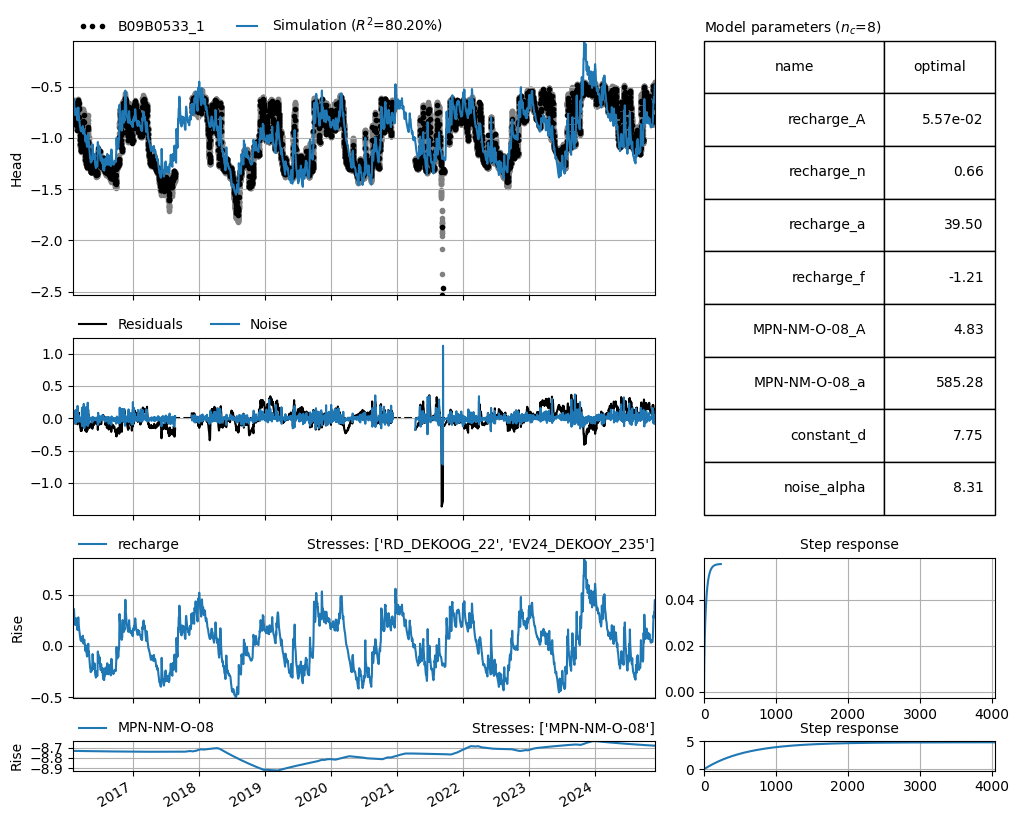

In [ ]:
# consider this model with a response function with a high response tmax
ml3 = ps.io.load("data/B09B0533_1_02.pas")
ml3.solve()
ml3.plots.results()
print(
    f"\nthe tmax of the recharge response is {ml3.get_response_tmax('recharge'):.0f} days"
)

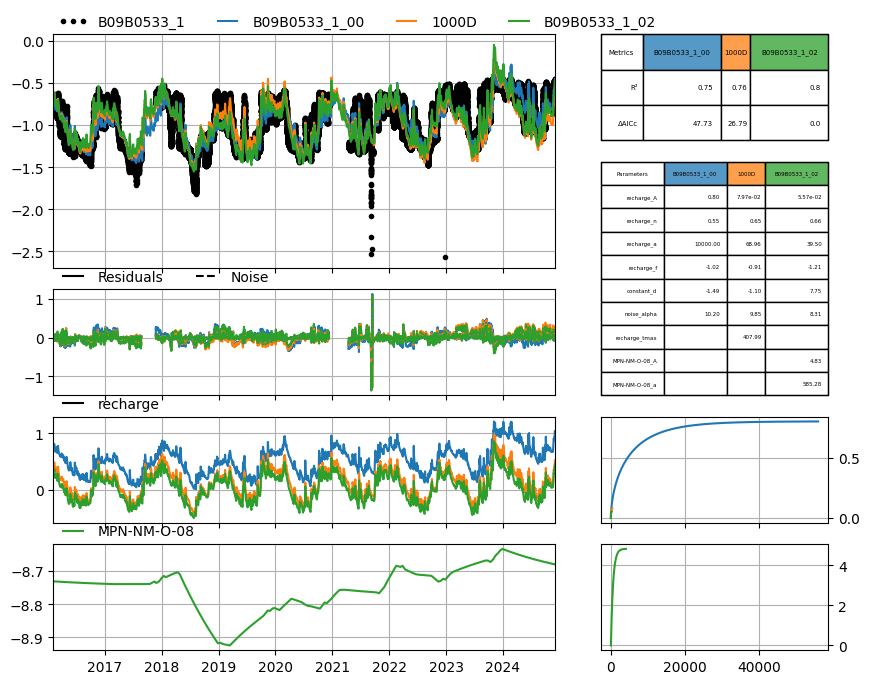

In [10]:
mc = ps.CompareModels(models=[ml, ml2, ml3])
mc.plot()